<table>
<tr>
<td>V1 </td>
<td>Simple feature engineering</td>
<td>second</td>
</tr>
<tr>
<td>V2 </td>
<td>Add pressure and inefficiency</td>
<td>second</td>
</tr>    
</table>



| Version   |      Date      |  Score | Score 2
|----------|:-------------:|------:|--:|
| Baseline |  20240110 | 6.407770748115235 |
| Imb, pressure, inefficiency |    20240110   |   6.302917211424277 ||
| Add WAP 30 Moving average | 20240112 |  6.302853946841688  ||
| Add WAP 60, 120, 240 Moving average | 20240112 |  6.3019380482507374 | 6.302636961287867 ||
| Polynomial features | 20240222| 6.300027022932713|6.315463191662042|

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
!pip install lightgbm
!pip install xgboost
!pip install catboost
!pip install optuna

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import joblib 
import os
import sklearn 
import matplotlib.pyplot as plt
from load_data import load_data_from_csv

In [2]:
from data_preprocessor.data_preprocessor import CompositeDataPreprocessor, ReduceMemUsageDataPreprocessor, FillNaPreProcessor
from data_preprocessor.feature_engineering import MovingAvgPreProcessor, RemoveIrrelevantFeaturesDataPreprocessor, DropTargetNADataPreprocessor, DTWKMeansPreprocessor
from data_preprocessor.polynomial_features import PolynomialFeaturesPreProcessor

In [3]:
from data_generator.data_generator import DefaultTrainEvalDataGenerator, ManualKFoldDataGenerator

from model_pipeline.lgb_pipeline import LGBModelPipelineFactory
from model_pipeline.xgb_pipeline import XGBModelPipelineFactory
from model_pipeline.cbt_pipeline import CatBoostModelPipelineFactory

from model_post_processor.model_post_processor import CompositeModelPostProcessor, SaveModelPostProcessor

from train_pipeline.train_pipeline import DefaultTrainPipeline

from train_pipeline.train_pipeline_callbacks import MAECallback
from utils.scoring_utils import ScoringUtils
from model_pipeline.dummy_models import BaselineEstimator

C:\Users\cchk3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preprocessing pipeline

In [11]:
processors = [  
    DTWKMeansPreprocessor(),
    # ReduceMemUsageDataPreprocessor(verbose=True),
    # MovingAvgPreProcessor("wap"),    
    # DropTargetNADataPreprocessor(),    
    # RemoveIrrelevantFeaturesDataPreprocessor(['stock_id', 'date_id','time_id', 'row_id']),
    # FillNaPreProcessor(),
    # PolynomialFeaturesPreProcessor(),
]
processor = CompositeDataPreprocessor(processors)

### Load data

In [4]:
# DATA_PATH = '/kaggle/input'
DATA_PATH = r'G:\My Drive\Script\Github\Data\optiver-trading-at-the-close'
df_train, df_test, revealed_targets, sample_submission = load_data_from_csv(DATA_PATH)
print(df_train.columns)

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')


In [6]:
df_train.dtypes

stock_id                     int64
date_id                      int64
seconds_in_bucket            int64
imbalance_size             float64
imbalance_buy_sell_flag      int64
reference_price            float64
matched_size               float64
far_price                  float64
near_price                 float64
bid_price                  float64
bid_size                   float64
ask_price                  float64
ask_size                   float64
wap                        float64
target                     float64
time_id                      int64
row_id                      object
dtype: object

### Pre-process data

In [5]:
# df_train = processor.apply(df_train)
print(df_train.shape[0])
print(df_train.columns)
display(df_train.head())
display(df_train.tail())

5237980
Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198
5237979,199,480,540,1884285.71,-1,1.002129,24073677.32,1.000859,1.001494,1.002129,250081.44,1.002447,300167.56,1.002274,-6.530285,26454,480_540_199


In [ ]:
data = [{'a': 1, 'b': 2, 'c': 3},
        {'a': 10, 'b': 20, 'c': 30}]
 
# Creates DataFrame.
df = pd.DataFrame(data)
df

,a,b,c
0,1,2,3
1,10,20,30


In [ ]:
int(301/2)

150

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True)
df = poly.fit_transform(df).astype("float32")
df.shape

(2, 7)

In [6]:

data_preprocessor = DTWKMeansPreprocessor(target_col_name='wap')
print(df_train.columns)

df_train.set_index(['date_id', 'time_id', 'stock_id'], inplace=True)
df_unstacked = df_train.unstack(level='stock_id')
df_unstacked.columns = ['_'.join(map(str, col)).strip() for col in df_unstacked.columns.values]
pivoted_df = df_unstacked.fillna(0)
pivoted_df.reset_index(inplace=True)
relevant_columns = [col for col in pivoted_df.columns if col.startswith(data_preprocessor.target_col_name)]
pivoted_df = pivoted_df[relevant_columns]
time_series_data = pivoted_df.to_numpy()

inertias= data_preprocessor.fit(time_series_data, max_clusters=10)


Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')


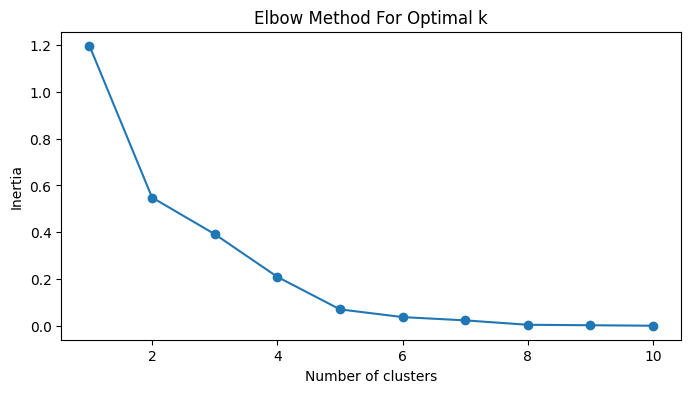

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

## Train

In [28]:
os.system('mkdir models')

1

In [ ]:
N_fold = 5
model_save_dir = './models/'

In [30]:
default_data_generator = DefaultTrainEvalDataGenerator()
k_fold_data_generator = ManualKFoldDataGenerator(n_fold=N_fold)

In [31]:
model_post_processor = CompositeModelPostProcessor([
    SaveModelPostProcessor(save_dir=model_save_dir)
])

In [26]:
lgb_pipeline = DefaultTrainPipeline(LGBModelPipelineFactory(), k_fold_data_generator, model_post_processor, [MAECallback()])

In [27]:
lgb_models, lgb_model_res, lgb_train_dfs, lgb_eval_dfs, lgb_num_train_eval_sets, lgb_callback_results = lgb_pipeline.train(df_train)

generate data
start training, num_train_eval_sets: 5
Training fold 0 - start
Training fold 0 - initialized
Training fold 0 - train size: (4190384, 18), eval size: (1047596, 18)
Training fold 0 - start training


ValueError: Input y contains NaN.

In [ ]:
lgb_avg_mae = ScoringUtils.calculate_mae(lgb_models, lgb_eval_dfs)
print(lgb_avg_mae)

6.315463191662042


In [ ]:
baseline_avg_mae = ScoringUtils.calculate_mae([BaselineEstimator()], [df_train])
print(baseline_avg_mae)

6.40777074786513


# Load

In [ ]:
models = []

In [ ]:
def load(modelname, fold):
    models.append(joblib.load(f'models/{modelname}_{fold}.model'))

In [ ]:
for i in range (0, 5):
    load('lgb', i)
    # load('xgb', i)
    # load('cbt', i)

In [ ]:
models

# Submit

In [ ]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [ ]:
test_processors = [
    EnrichDFDataPreprocessor(),
    RemoveIrrelevantFeaturesDataPreprocessor(['stock_id', 'date_id','time_id', 'row_id'])    
]
test_processor = CompositeDataPreprocessor(processors)

In [ ]:
counter = 0
cache = pd.DataFrame()

for (test, revealed_targets, sample_prediction) in iter_test:
    test_ = processor.apply(test)
    cache = pd.concat([cache, test_], ignore_index=True, axis=0)  
    sample_prediction['target'] = np.mean([model.predict(test_) for model in models], 0)
    env.predict(sample_prediction)
    counter += 1

In [ ]:
# sample_prediction['target'] = 0
# env.predict(sample_prediction)

In [ ]:
# counter = 0
# # sample_prediction['target'] = 0
# # env.predict(sample_prediction)
# for (test, revealed_targets, sample_prediction) in iter_test:
# #     print(test.shape)
#     test_ = enrich_df_with_features(test)[features]
# #     print(test_.shape)
# #     print(len(features))
# #     print(len(test_))
#     sample_prediction['target'] = np.mean([model.predict(test_) for model in models], 0)
#     env.predict(sample_prediction)
#     counter += 1